# 读取文件，**写文件名

In [1]:
import pandas as pd
df = pd.read_csv('**.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 11 columns):
edema_T1WI_squareroot_glrlm_RunPercentage                       188 non-null float64
edema_T1WI_wavelet-LH_glrlm_RunLengthNonUniformityNormalized    188 non-null float64
edema_T2WI_wavelet-HL_gldm_DependenceNonUniformityNormalized    188 non-null float64
edema_T2WI_square_glrlm_GrayLevelNonUniformityNormalized        188 non-null float64
edema_T1WI_squareroot_glcm_DifferenceAverage                    188 non-null float64
edema_T1WI_wavelet-HH_glcm_MaximumProbability                   188 non-null float64
edema_T2-FLAIR_log-sigma-4-0-mm-3D_glcm_DifferenceEntropy       188 non-null float64
edema_ADC_wavelet-LL_glcm_DifferenceAverage                     188 non-null float64
edema_ADC_squareroot_firstorder_RobustMeanAbsoluteDeviation     188 non-null float64
edema_ADC_wavelet-LL_firstorder_Entropy                         188 non-null float64
Y                                            

# 数据预处理，去除一些缺失值

In [2]:
df_drop = df.dropna(axis=0)
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 0 to 187
Data columns (total 11 columns):
edema_T1WI_squareroot_glrlm_RunPercentage                       188 non-null float64
edema_T1WI_wavelet-LH_glrlm_RunLengthNonUniformityNormalized    188 non-null float64
edema_T2WI_wavelet-HL_gldm_DependenceNonUniformityNormalized    188 non-null float64
edema_T2WI_square_glrlm_GrayLevelNonUniformityNormalized        188 non-null float64
edema_T1WI_squareroot_glcm_DifferenceAverage                    188 non-null float64
edema_T1WI_wavelet-HH_glcm_MaximumProbability                   188 non-null float64
edema_T2-FLAIR_log-sigma-4-0-mm-3D_glcm_DifferenceEntropy       188 non-null float64
edema_ADC_wavelet-LL_glcm_DifferenceAverage                     188 non-null float64
edema_ADC_squareroot_firstorder_RobustMeanAbsoluteDeviation     188 non-null float64
edema_ADC_wavelet-LL_firstorder_Entropy                         188 non-null float64
Y                                            

In [3]:
import numpy as np
df_drop.replace([np.inf, -np.inf],np.nan,inplace=True)
df_drop.fillna(0,inplace=True)
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 0 to 187
Data columns (total 11 columns):
edema_T1WI_squareroot_glrlm_RunPercentage                       188 non-null float64
edema_T1WI_wavelet-LH_glrlm_RunLengthNonUniformityNormalized    188 non-null float64
edema_T2WI_wavelet-HL_gldm_DependenceNonUniformityNormalized    188 non-null float64
edema_T2WI_square_glrlm_GrayLevelNonUniformityNormalized        188 non-null float64
edema_T1WI_squareroot_glcm_DifferenceAverage                    188 non-null float64
edema_T1WI_wavelet-HH_glcm_MaximumProbability                   188 non-null float64
edema_T2-FLAIR_log-sigma-4-0-mm-3D_glcm_DifferenceEntropy       188 non-null float64
edema_ADC_wavelet-LL_glcm_DifferenceAverage                     188 non-null float64
edema_ADC_squareroot_firstorder_RobustMeanAbsoluteDeviation     188 non-null float64
edema_ADC_wavelet-LL_firstorder_Entropy                         188 non-null float64
Y                                            

# 赋标签，Y指label值，换成自己的label名称

In [4]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df_drop['Y']))}
class_mapping

{'NS': 0, 'S': 1}

# X选择label之外的列，y为label列

In [5]:
from sklearn.preprocessing import LabelEncoder
df_drop['Y'] = df_drop['Y'].map(class_mapping)
y = LabelEncoder().fit_transform(df_drop['Y'].values)
X = df_drop.iloc[:, 0:10].values
print(y.shape)
print(X.shape)

(188,)
(188, 10)


# 获取每列的名称

In [6]:
feat_labels = df_drop.columns[0:10]

# 数据标准化

In [7]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)
print(X_std.shape)

(188, 10)


# 随机森林评分特征

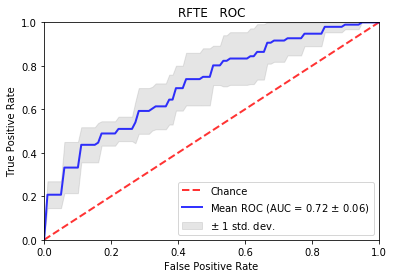

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from scipy import interp
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(bootstrap=True,criterion='gini',oob_score=True,n_jobs=-1,
                                max_features='sqrt',n_estimators=500,min_samples_leaf=10,
                                random_state=50)
cv = StratifiedKFold(n_splits=5)
classifier = forest
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X_std, y):
    probas_ = classifier.fit(X_std[train], y[train]).predict_proba(X_std[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RFTE   ROC')
plt.legend(loc="lower right" ,
           #fontsize = 'xx-small'
          )
#plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()

# 保存最终学习到的模型

In [ ]:
from sklearn.externals import joblib
joblib.dump(classifier, 'train.pkl')